In [12]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/division_qa/qa.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/division_qa/qa.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'


In [13]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [14]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [15]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [16]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


In [18]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 110/110 [00:13<00:00,  8.02it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 110/110 [00:00<00:00, 141.11it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 38/38 [00:04<00:00,  8.23it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 38/38 [00:00<00:00, 146.18it/s]


In [19]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]

Training Epochs:   1%|          | 20/2000 [00:00<00:33, 58.60it/s]

Epoch 10/2000, Loss: 0.5726
Test Accuracy at Epoch 10: 58.47%
Test F1-score at Epoch 10: 0.7135
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.23      0.27      0.25        30
non_infringement       0.73      0.69      0.71        88

        accuracy                           0.58       118
       macro avg       0.48      0.48      0.48       118
    weighted avg       0.61      0.58      0.59       118

New best model saved with F1-score 0.7135 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.23      0.27      0.25        30
non_infringement       0.73      0.69      0.71        88

        accuracy                           0.58       118
       macro avg       0.48      0.48      0.48       118
    weighted avg       0.61      0.58      0.59       118

Epoch 20/2000, Loss: 0.5321
Test Accuracy at Epoch 20: 62.71%
Test F1-sco

Training Epochs:   2%|▏         | 37/2000 [00:00<00:30, 64.29it/s]

Epoch 30/2000, Loss: 0.4672
Test Accuracy at Epoch 30: 72.88%
Test F1-score at Epoch 30: 0.8431
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00        30
non_infringement       0.74      0.98      0.84        88

        accuracy                           0.73       118
       macro avg       0.37      0.49      0.42       118
    weighted avg       0.55      0.73      0.63       118

New best model saved with F1-score 0.8431 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00        30
non_infringement       0.74      0.98      0.84        88

        accuracy                           0.73       118
       macro avg       0.37      0.49      0.42       118
    weighted avg       0.55      0.73      0.63       118

Epoch 40/2000, Loss: 0.4011
Test Accuracy at Epoch 40: 67.80%
Test F1-sco

Training Epochs:   3%|▎         | 62/2000 [00:00<00:25, 74.67it/s]

Epoch 50/2000, Loss: 0.3694
Test Accuracy at Epoch 50: 64.41%
Test F1-score at Epoch 50: 0.7717
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.23      0.17      0.19        30
non_infringement       0.74      0.81      0.77        88

        accuracy                           0.64       118
       macro avg       0.48      0.49      0.48       118
    weighted avg       0.61      0.64      0.62       118

Epoch 60/2000, Loss: 0.2623
Test Accuracy at Epoch 60: 64.41%
Test F1-score at Epoch 60: 0.7742
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.20      0.13      0.16        30
non_infringement       0.73      0.82      0.77        88

        accuracy                           0.64       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.64      0.62       118



Training Epochs:   4%|▍         | 78/2000 [00:01<00:33, 58.15it/s]

Epoch 70/2000, Loss: 0.1936
Test Accuracy at Epoch 70: 66.95%
Test F1-score at Epoch 70: 0.7958
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.20      0.10      0.13        30
non_infringement       0.74      0.86      0.80        88

        accuracy                           0.67       118
       macro avg       0.47      0.48      0.46       118
    weighted avg       0.60      0.67      0.63       118

Epoch 80/2000, Loss: 0.1203
Test Accuracy at Epoch 80: 66.95%
Test F1-score at Epoch 80: 0.7958
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.20      0.10      0.13        30
non_infringement       0.74      0.86      0.80        88

        accuracy                           0.67       118
       macro avg       0.47      0.48      0.46       118
    weighted avg       0.60      0.67      0.63       118



Training Epochs:   5%|▌         | 103/2000 [00:01<00:27, 69.31it/s]

Epoch 90/2000, Loss: 0.2003
Test Accuracy at Epoch 90: 65.25%
Test F1-score at Epoch 90: 0.7735
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.28      0.23      0.25        30
non_infringement       0.75      0.80      0.77        88

        accuracy                           0.65       118
       macro avg       0.52      0.51      0.51       118
    weighted avg       0.63      0.65      0.64       118

Epoch 100/2000, Loss: 0.1996
Test Accuracy at Epoch 100: 66.10%
Test F1-score at Epoch 100: 0.7872
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.22      0.13      0.17        30
non_infringement       0.74      0.84      0.79        88

        accuracy                           0.66       118
       macro avg       0.48      0.49      0.48       118
    weighted avg       0.61      0.66      0.63       118



Training Epochs:   6%|▌         | 120/2000 [00:01<00:26, 71.59it/s]

Epoch 110/2000, Loss: 0.1169
Test Accuracy at Epoch 110: 66.10%
Test F1-score at Epoch 110: 0.7872
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.22      0.13      0.17        30
non_infringement       0.74      0.84      0.79        88

        accuracy                           0.66       118
       macro avg       0.48      0.49      0.48       118
    weighted avg       0.61      0.66      0.63       118

Epoch 120/2000, Loss: 0.0732
Test Accuracy at Epoch 120: 66.10%
Test F1-score at Epoch 120: 0.7872
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.22      0.13      0.17        30
non_infringement       0.74      0.84      0.79        88

        accuracy                           0.66       118
       macro avg       0.48      0.49      0.48       118
    weighted avg       0.61      0.66      0.63       118



Training Epochs:   6%|▋         | 128/2000 [00:01<00:25, 73.76it/s]

Epoch 130/2000, Loss: 0.0442
Test Accuracy at Epoch 130: 66.10%
Test F1-score at Epoch 130: 0.7872
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.22      0.13      0.17        30
non_infringement       0.74      0.84      0.79        88

        accuracy                           0.66       118
       macro avg       0.48      0.49      0.48       118
    weighted avg       0.61      0.66      0.63       118



Training Epochs:   8%|▊         | 150/2000 [00:03<00:57, 32.33it/s]

Epoch 140/2000, Loss: 0.0267
Test Accuracy at Epoch 140: 66.10%
Test F1-score at Epoch 140: 0.7872
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.22      0.13      0.17        30
non_infringement       0.74      0.84      0.79        88

        accuracy                           0.66       118
       macro avg       0.48      0.49      0.48       118
    weighted avg       0.61      0.66      0.63       118

Epoch 150/2000, Loss: 0.0164
Test Accuracy at Epoch 150: 65.25%
Test F1-score at Epoch 150: 0.7807
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:   8%|▊         | 166/2000 [00:03<00:41, 43.91it/s]

Epoch 160/2000, Loss: 0.0111
Test Accuracy at Epoch 160: 66.10%
Test F1-score at Epoch 160: 0.7849
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 170/2000, Loss: 0.0085
Test Accuracy at Epoch 170: 65.25%
Test F1-score at Epoch 170: 0.7807
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:   9%|▉         | 179/2000 [00:03<00:38, 47.07it/s]

Epoch 180/2000, Loss: 0.0070
Test Accuracy at Epoch 180: 65.25%
Test F1-score at Epoch 180: 0.7807
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  10%|▉         | 199/2000 [00:04<00:40, 44.07it/s]

Epoch 190/2000, Loss: 0.0061
Test Accuracy at Epoch 190: 65.25%
Test F1-score at Epoch 190: 0.7807
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 200/2000, Loss: 0.0055
Test Accuracy at Epoch 200: 65.25%
Test F1-score at Epoch 200: 0.7807
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  11%|█         | 222/2000 [00:04<00:28, 62.86it/s]

Epoch 210/2000, Loss: 0.0051
Test Accuracy at Epoch 210: 65.25%
Test F1-score at Epoch 210: 0.7807
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 220/2000, Loss: 0.0048
Test Accuracy at Epoch 220: 65.25%
Test F1-score at Epoch 220: 0.7807
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  12%|█▏        | 240/2000 [00:04<00:24, 71.32it/s]

Epoch 230/2000, Loss: 0.0045
Test Accuracy at Epoch 230: 65.25%
Test F1-score at Epoch 230: 0.7807
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 240/2000, Loss: 0.0043
Test Accuracy at Epoch 240: 65.25%
Test F1-score at Epoch 240: 0.7807
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  13%|█▎        | 256/2000 [00:04<00:26, 66.47it/s]

Epoch 250/2000, Loss: 0.0042
Test Accuracy at Epoch 250: 65.25%
Test F1-score at Epoch 250: 0.7807
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 260/2000, Loss: 0.0041
Test Accuracy at Epoch 260: 65.25%
Test F1-score at Epoch 260: 0.7807
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  14%|█▍        | 283/2000 [00:05<00:21, 79.73it/s]

Epoch 270/2000, Loss: 0.0039
Test Accuracy at Epoch 270: 65.25%
Test F1-score at Epoch 270: 0.7807
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 280/2000, Loss: 0.0039
Test Accuracy at Epoch 280: 65.25%
Test F1-score at Epoch 280: 0.7807
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  15%|█▌        | 301/2000 [00:05<00:20, 82.41it/s]

Epoch 290/2000, Loss: 0.0038
Test Accuracy at Epoch 290: 65.25%
Test F1-score at Epoch 290: 0.7807
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 300/2000, Loss: 0.0037
Test Accuracy at Epoch 300: 65.25%
Test F1-score at Epoch 300: 0.7807
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  16%|█▌        | 320/2000 [00:05<00:19, 84.99it/s]

Epoch 310/2000, Loss: 0.0036
Test Accuracy at Epoch 310: 65.25%
Test F1-score at Epoch 310: 0.7807
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 320/2000, Loss: 0.0036
Test Accuracy at Epoch 320: 65.25%
Test F1-score at Epoch 320: 0.7807
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  17%|█▋        | 347/2000 [00:06<00:21, 77.39it/s]

Epoch 330/2000, Loss: 0.0035
Test Accuracy at Epoch 330: 65.25%
Test F1-score at Epoch 330: 0.7807
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 340/2000, Loss: 0.0035
Test Accuracy at Epoch 340: 65.25%
Test F1-score at Epoch 340: 0.7807
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  18%|█▊        | 365/2000 [00:06<00:19, 81.81it/s]

Epoch 350/2000, Loss: 0.0035
Test Accuracy at Epoch 350: 65.25%
Test F1-score at Epoch 350: 0.7807
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 360/2000, Loss: 0.0034
Test Accuracy at Epoch 360: 65.25%
Test F1-score at Epoch 360: 0.7807
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  19%|█▉        | 383/2000 [00:06<00:19, 84.97it/s]

Epoch 370/2000, Loss: 0.0034
Test Accuracy at Epoch 370: 65.25%
Test F1-score at Epoch 370: 0.7807
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 380/2000, Loss: 0.0034
Test Accuracy at Epoch 380: 65.25%
Test F1-score at Epoch 380: 0.7807
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  20%|██        | 401/2000 [00:06<00:18, 84.56it/s]

Epoch 390/2000, Loss: 0.0034
Test Accuracy at Epoch 390: 65.25%
Test F1-score at Epoch 390: 0.7807
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 400/2000, Loss: 0.0033
Test Accuracy at Epoch 400: 65.25%
Test F1-score at Epoch 400: 0.7807
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  21%|██        | 420/2000 [00:06<00:18, 85.07it/s]

Epoch 410/2000, Loss: 0.0033
Test Accuracy at Epoch 410: 65.25%
Test F1-score at Epoch 410: 0.7807
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 420/2000, Loss: 0.0033
Test Accuracy at Epoch 420: 65.25%
Test F1-score at Epoch 420: 0.7807
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  22%|██▏       | 440/2000 [00:07<00:17, 88.29it/s]

Epoch 430/2000, Loss: 0.0033
Test Accuracy at Epoch 430: 65.25%
Test F1-score at Epoch 430: 0.7807
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 440/2000, Loss: 0.0033
Test Accuracy at Epoch 440: 65.25%
Test F1-score at Epoch 440: 0.7807
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  23%|██▎       | 467/2000 [00:07<00:17, 86.31it/s]

Epoch 450/2000, Loss: 0.0032
Test Accuracy at Epoch 450: 65.25%
Test F1-score at Epoch 450: 0.7807
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 460/2000, Loss: 0.0032
Test Accuracy at Epoch 460: 65.25%
Test F1-score at Epoch 460: 0.7807
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  24%|██▍       | 477/2000 [00:07<00:17, 88.85it/s]

Epoch 470/2000, Loss: 0.0032
Test Accuracy at Epoch 470: 65.25%
Test F1-score at Epoch 470: 0.7807
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 480/2000, Loss: 0.0032
Test Accuracy at Epoch 480: 65.25%
Test F1-score at Epoch 480: 0.7807
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  25%|██▌       | 503/2000 [00:08<00:39, 37.73it/s]

Epoch 490/2000, Loss: 0.0032
Test Accuracy at Epoch 490: 65.25%
Test F1-score at Epoch 490: 0.7807
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 500/2000, Loss: 0.0032
Test Accuracy at Epoch 500: 65.25%
Test F1-score at Epoch 500: 0.7807
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  26%|██▌       | 518/2000 [00:09<00:34, 42.95it/s]

Epoch 510/2000, Loss: 0.0032
Test Accuracy at Epoch 510: 65.25%
Test F1-score at Epoch 510: 0.7807
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 520/2000, Loss: 0.0032
Test Accuracy at Epoch 520: 65.25%
Test F1-score at Epoch 520: 0.7807
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  27%|██▋       | 538/2000 [00:09<00:31, 47.06it/s]

Epoch 530/2000, Loss: 0.0032
Test Accuracy at Epoch 530: 65.25%
Test F1-score at Epoch 530: 0.7807
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 540/2000, Loss: 0.0031
Test Accuracy at Epoch 540: 65.25%
Test F1-score at Epoch 540: 0.7807


Training Epochs:  27%|██▋       | 544/2000 [00:09<00:32, 44.68it/s]

Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  28%|██▊       | 550/2000 [00:09<00:32, 44.18it/s]

Epoch 550/2000, Loss: 0.0031
Test Accuracy at Epoch 550: 65.25%
Test F1-score at Epoch 550: 0.7807
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  28%|██▊       | 559/2000 [00:10<01:24, 17.03it/s]

Epoch 560/2000, Loss: 0.0033
Test Accuracy at Epoch 560: 65.25%
Test F1-score at Epoch 560: 0.7807
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  28%|██▊       | 568/2000 [00:11<01:19, 17.97it/s]

Epoch 570/2000, Loss: 0.0031
Test Accuracy at Epoch 570: 65.25%
Test F1-score at Epoch 570: 0.7807
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  30%|██▉       | 594/2000 [00:13<01:06, 21.26it/s]

Epoch 580/2000, Loss: 0.0032
Test Accuracy at Epoch 580: 66.10%
Test F1-score at Epoch 580: 0.7849
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 590/2000, Loss: 0.0032
Test Accuracy at Epoch 590: 66.10%
Test F1-score at Epoch 590: 0.7849
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 600/2000, Loss: 0.0031

Training Epochs:  31%|███       | 614/2000 [00:13<00:35, 38.72it/s]

Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 610/2000, Loss: 0.0032
Test Accuracy at Epoch 610: 66.10%
Test F1-score at Epoch 610: 0.7849
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 620/2000, Loss: 0.0032
Test Accuracy at Epoch 620: 66.10%
Test F1-score at Epoch 620: 0.7849
Classification Report at Epo

Training Epochs:  31%|███       | 624/2000 [00:14<00:40, 33.76it/s]

Epoch 630/2000, Loss: 0.0031
Test Accuracy at Epoch 630: 65.25%
Test F1-score at Epoch 630: 0.7807
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  32%|███▏      | 636/2000 [00:14<00:56, 24.28it/s]

Epoch 640/2000, Loss: 0.0031
Test Accuracy at Epoch 640: 65.25%
Test F1-score at Epoch 640: 0.7807
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  33%|███▎      | 664/2000 [00:15<00:32, 40.94it/s]

Epoch 650/2000, Loss: 0.0031
Test Accuracy at Epoch 650: 65.25%
Test F1-score at Epoch 650: 0.7807
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 660/2000, Loss: 0.0031
Test Accuracy at Epoch 660: 65.25%
Test F1-score at Epoch 660: 0.7807
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 670/2000, Loss: 0.0031

Training Epochs:  34%|███▍      | 681/2000 [00:16<01:07, 19.61it/s]

Epoch 680/2000, Loss: 0.0031
Test Accuracy at Epoch 680: 65.25%
Test F1-score at Epoch 680: 0.7807
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  35%|███▍      | 697/2000 [00:17<01:04, 20.31it/s]

Epoch 690/2000, Loss: 0.0031
Test Accuracy at Epoch 690: 65.25%
Test F1-score at Epoch 690: 0.7807
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 700/2000, Loss: 0.0031
Test Accuracy at Epoch 700: 65.25%
Test F1-score at Epoch 700: 0.7807


Training Epochs:  35%|███▌      | 701/2000 [00:18<01:10, 18.39it/s]

Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  36%|███▌      | 713/2000 [00:18<00:48, 26.75it/s]

Epoch 710/2000, Loss: 0.0033
Test Accuracy at Epoch 710: 65.25%
Test F1-score at Epoch 710: 0.7807
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  36%|███▋      | 730/2000 [00:18<00:32, 38.86it/s]

Epoch 720/2000, Loss: 0.0031
Test Accuracy at Epoch 720: 65.25%
Test F1-score at Epoch 720: 0.7807
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 730/2000, Loss: 0.0031
Test Accuracy at Epoch 730: 66.10%
Test F1-score at Epoch 730: 0.7849
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118



Training Epochs:  37%|███▋      | 741/2000 [00:19<00:39, 32.24it/s]

Epoch 740/2000, Loss: 0.0031
Test Accuracy at Epoch 740: 65.25%
Test F1-score at Epoch 740: 0.7807
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  38%|███▊      | 760/2000 [00:19<00:26, 45.97it/s]

Epoch 750/2000, Loss: 0.0031
Test Accuracy at Epoch 750: 66.10%
Test F1-score at Epoch 750: 0.7849
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 760/2000, Loss: 0.0032
Test Accuracy at Epoch 760: 66.10%
Test F1-score at Epoch 760: 0.7849
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118



Training Epochs:  39%|███▉      | 787/2000 [00:19<00:16, 71.47it/s]

Epoch 770/2000, Loss: 0.0030
Test Accuracy at Epoch 770: 65.25%
Test F1-score at Epoch 770: 0.7807
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 780/2000, Loss: 0.0030
Test Accuracy at Epoch 780: 65.25%
Test F1-score at Epoch 780: 0.7807
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  40%|███▉      | 795/2000 [00:20<00:18, 64.12it/s]

Epoch 790/2000, Loss: 0.0031
Test Accuracy at Epoch 790: 65.25%
Test F1-score at Epoch 790: 0.7807
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 800/2000, Loss: 0.0031


Training Epochs:  40%|████      | 809/2000 [00:20<00:20, 59.04it/s]

Test Accuracy at Epoch 800: 65.25%
Test F1-score at Epoch 800: 0.7807
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 810/2000, Loss: 0.0030
Test Accuracy at Epoch 810: 65.25%
Test F1-score at Epoch 810: 0.7807
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  42%|████▏     | 834/2000 [00:20<00:16, 68.87it/s]

Epoch 820/2000, Loss: 0.0031
Test Accuracy at Epoch 820: 66.10%
Test F1-score at Epoch 820: 0.7849
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 830/2000, Loss: 0.0031
Test Accuracy at Epoch 830: 66.10%
Test F1-score at Epoch 830: 0.7849
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118



Training Epochs:  43%|████▎     | 853/2000 [00:20<00:14, 78.77it/s]

Epoch 840/2000, Loss: 0.0031
Test Accuracy at Epoch 840: 66.10%
Test F1-score at Epoch 840: 0.7849
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 850/2000, Loss: 0.0031
Test Accuracy at Epoch 850: 66.10%
Test F1-score at Epoch 850: 0.7849
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118



Training Epochs:  44%|████▎     | 872/2000 [00:21<00:13, 84.79it/s]

Epoch 860/2000, Loss: 0.0031
Test Accuracy at Epoch 860: 66.10%
Test F1-score at Epoch 860: 0.7849
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 870/2000, Loss: 0.0031
Test Accuracy at Epoch 870: 66.10%
Test F1-score at Epoch 870: 0.7849
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118



Training Epochs:  45%|████▍     | 892/2000 [00:21<00:12, 88.77it/s]

Epoch 880/2000, Loss: 0.0031
Test Accuracy at Epoch 880: 66.10%
Test F1-score at Epoch 880: 0.7849
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 890/2000, Loss: 0.0030
Test Accuracy at Epoch 890: 66.10%
Test F1-score at Epoch 890: 0.7849
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118



Training Epochs:  46%|████▌     | 911/2000 [00:21<00:13, 80.69it/s]

Epoch 900/2000, Loss: 0.0031
Test Accuracy at Epoch 900: 66.10%
Test F1-score at Epoch 900: 0.7849
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 910/2000, Loss: 0.0031
Test Accuracy at Epoch 910: 66.10%
Test F1-score at Epoch 910: 0.7849
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118



Training Epochs:  47%|████▋     | 931/2000 [00:21<00:12, 87.07it/s]

Epoch 920/2000, Loss: 0.0030
Test Accuracy at Epoch 920: 66.10%
Test F1-score at Epoch 920: 0.7849
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 930/2000, Loss: 0.0030
Test Accuracy at Epoch 930: 65.25%
Test F1-score at Epoch 930: 0.7807
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  48%|████▊     | 951/2000 [00:21<00:11, 90.56it/s]

Epoch 940/2000, Loss: 0.0031
Test Accuracy at Epoch 940: 66.10%
Test F1-score at Epoch 940: 0.7849
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 950/2000, Loss: 0.0031
Test Accuracy at Epoch 950: 66.10%
Test F1-score at Epoch 950: 0.7849
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118



Training Epochs:  48%|████▊     | 970/2000 [00:22<00:12, 84.15it/s]

Epoch 960/2000, Loss: 0.0030
Test Accuracy at Epoch 960: 65.25%
Test F1-score at Epoch 960: 0.7807
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 970/2000, Loss: 0.0030
Test Accuracy at Epoch 970: 65.25%
Test F1-score at Epoch 970: 0.7807
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  49%|████▉     | 979/2000 [00:22<00:13, 74.64it/s]

Epoch 980/2000, Loss: 0.0030
Test Accuracy at Epoch 980: 65.25%
Test F1-score at Epoch 980: 0.7807
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  50%|████▉     | 994/2000 [00:22<00:21, 47.80it/s]

Epoch 990/2000, Loss: 0.0031
Test Accuracy at Epoch 990: 65.25%
Test F1-score at Epoch 990: 0.7807
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1000/2000, Loss: 0.0030
Test Accuracy at Epoch 1000: 65.25%
Test F1-score at Epoch 1000: 0.7807
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  51%|█████     | 1019/2000 [00:24<00:31, 30.72it/s]

Epoch 1010/2000, Loss: 0.0030
Test Accuracy at Epoch 1010: 65.25%
Test F1-score at Epoch 1010: 0.7807
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1020/2000, Loss: 0.0030
Test Accuracy at Epoch 1020: 65.25%
Test F1-score at Epoch 1020: 0.7807
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  52%|█████▏    | 1042/2000 [00:24<00:22, 42.94it/s]

Epoch 1030/2000, Loss: 0.0031
Test Accuracy at Epoch 1030: 66.10%
Test F1-score at Epoch 1030: 0.7849
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 1040/2000, Loss: 0.0030
Test Accuracy at Epoch 1040: 66.10%
Test F1-score at Epoch 1040: 0.7849
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118



Training Epochs:  53%|█████▎    | 1056/2000 [00:24<00:19, 48.90it/s]

Epoch 1050/2000, Loss: 0.0030
Test Accuracy at Epoch 1050: 65.25%
Test F1-score at Epoch 1050: 0.7807
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1060/2000, Loss: 0.0030
Test Accuracy at Epoch 1060: 65.25%
Test F1-score at Epoch 1060: 0.7807
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  54%|█████▍    | 1081/2000 [00:25<00:25, 36.32it/s]

Epoch 1070/2000, Loss: 0.0030
Test Accuracy at Epoch 1070: 66.10%
Test F1-score at Epoch 1070: 0.7849
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 1080/2000, Loss: 0.0030
Test Accuracy at Epoch 1080: 66.10%
Test F1-score at Epoch 1080: 0.7849
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118



Training Epochs:  55%|█████▌    | 1100/2000 [00:26<00:20, 44.18it/s]

Epoch 1090/2000, Loss: 0.0031
Test Accuracy at Epoch 1090: 66.10%
Test F1-score at Epoch 1090: 0.7849
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 1100/2000, Loss: 0.0030
Test Accuracy at Epoch 1100: 65.25%
Test F1-score at Epoch 1100: 0.7807
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  56%|█████▌    | 1113/2000 [00:27<00:45, 19.37it/s]

Epoch 1110/2000, Loss: 0.0030
Test Accuracy at Epoch 1110: 65.25%
Test F1-score at Epoch 1110: 0.7807
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  56%|█████▋    | 1125/2000 [00:27<00:30, 28.59it/s]

Epoch 1120/2000, Loss: 0.0030
Test Accuracy at Epoch 1120: 65.25%
Test F1-score at Epoch 1120: 0.7807
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1130/2000, Loss: 0.0031
Test Accuracy at Epoch 1130: 65.25%
Test F1-score at Epoch 1130: 0.7807
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  58%|█████▊    | 1156/2000 [00:27<00:14, 59.25it/s]

Epoch 1140/2000, Loss: 0.0030
Test Accuracy at Epoch 1140: 65.25%
Test F1-score at Epoch 1140: 0.7807
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1150/2000, Loss: 0.0030
Test Accuracy at Epoch 1150: 65.25%
Test F1-score at Epoch 1150: 0.7807
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  59%|█████▉    | 1176/2000 [00:27<00:10, 76.50it/s]

Epoch 1160/2000, Loss: 0.0030
Test Accuracy at Epoch 1160: 65.25%
Test F1-score at Epoch 1160: 0.7807
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1170/2000, Loss: 0.0030
Test Accuracy at Epoch 1170: 65.25%
Test F1-score at Epoch 1170: 0.7807
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  60%|█████▉    | 1197/2000 [00:28<00:09, 88.36it/s]

Epoch 1180/2000, Loss: 0.0030
Test Accuracy at Epoch 1180: 66.10%
Test F1-score at Epoch 1180: 0.7849
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 1190/2000, Loss: 0.0030
Test Accuracy at Epoch 1190: 66.10%
Test F1-score at Epoch 1190: 0.7849
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 1200/2000, Los

Training Epochs:  60%|██████    | 1207/2000 [00:28<00:08, 91.49it/s]

Test Accuracy at Epoch 1200: 65.25%
Test F1-score at Epoch 1200: 0.7807
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1210/2000, Loss: 0.0030
Test Accuracy at Epoch 1210: 65.25%
Test F1-score at Epoch 1210: 0.7807
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  62%|██████▏   | 1233/2000 [00:31<00:50, 15.06it/s]

Epoch 1220/2000, Loss: 0.0030
Test Accuracy at Epoch 1220: 65.25%
Test F1-score at Epoch 1220: 0.7807
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1230/2000, Loss: 0.0030
Test Accuracy at Epoch 1230: 66.10%
Test F1-score at Epoch 1230: 0.7849
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118



Training Epochs:  63%|██████▎   | 1254/2000 [00:32<00:26, 28.31it/s]

Epoch 1240/2000, Loss: 0.0031
Test Accuracy at Epoch 1240: 66.10%
Test F1-score at Epoch 1240: 0.7849
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 1250/2000, Loss: 0.0030
Test Accuracy at Epoch 1250: 65.25%
Test F1-score at Epoch 1250: 0.7807
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1260/2000, Los

Training Epochs:  64%|██████▍   | 1275/2000 [00:32<00:16, 45.22it/s]

Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1270/2000, Loss: 0.0030
Test Accuracy at Epoch 1270: 65.25%
Test F1-score at Epoch 1270: 0.7807
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1280/2000, Loss: 0.0030
Test Accuracy at Epoch 1280: 65.25%
Test F1-score at Epoch 1280: 0.7807


Training Epochs:  64%|██████▍   | 1285/2000 [00:32<00:13, 53.68it/s]

Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1290/2000, Loss: 0.0030
Test Accuracy at Epoch 1290: 66.10%
Test F1-score at Epoch 1290: 0.7849
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118



Training Epochs:  66%|██████▌   | 1314/2000 [00:32<00:10, 66.22it/s]

Epoch 1300/2000, Loss: 0.0031
Test Accuracy at Epoch 1300: 66.10%
Test F1-score at Epoch 1300: 0.7849
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 1310/2000, Loss: 0.0030
Test Accuracy at Epoch 1310: 65.25%
Test F1-score at Epoch 1310: 0.7807
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  67%|██████▋   | 1332/2000 [00:33<00:09, 73.05it/s]

Epoch 1320/2000, Loss: 0.0030
Test Accuracy at Epoch 1320: 65.25%
Test F1-score at Epoch 1320: 0.7807
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1330/2000, Loss: 0.0030
Test Accuracy at Epoch 1330: 65.25%
Test F1-score at Epoch 1330: 0.7807
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  68%|██████▊   | 1351/2000 [00:33<00:08, 79.84it/s]

Epoch 1340/2000, Loss: 0.0030
Test Accuracy at Epoch 1340: 65.25%
Test F1-score at Epoch 1340: 0.7807
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1350/2000, Loss: 0.0030
Test Accuracy at Epoch 1350: 66.10%
Test F1-score at Epoch 1350: 0.7849
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118



Training Epochs:  68%|██████▊   | 1370/2000 [00:33<00:08, 75.20it/s]

Epoch 1360/2000, Loss: 0.0030
Test Accuracy at Epoch 1360: 66.10%
Test F1-score at Epoch 1360: 0.7849
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 1370/2000, Loss: 0.0030
Test Accuracy at Epoch 1370: 65.25%
Test F1-score at Epoch 1370: 0.7807
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  69%|██████▉   | 1387/2000 [00:33<00:09, 65.61it/s]

Epoch 1380/2000, Loss: 0.0030
Test Accuracy at Epoch 1380: 65.25%
Test F1-score at Epoch 1380: 0.7807
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1390/2000, Loss: 0.0030


Training Epochs:  70%|███████   | 1401/2000 [00:34<00:10, 58.35it/s]

Test Accuracy at Epoch 1390: 65.25%
Test F1-score at Epoch 1390: 0.7807
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1400/2000, Loss: 0.0030
Test Accuracy at Epoch 1400: 65.25%
Test F1-score at Epoch 1400: 0.7807
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  71%|███████   | 1415/2000 [00:34<00:10, 57.75it/s]

Epoch 1410/2000, Loss: 0.0030
Test Accuracy at Epoch 1410: 65.25%
Test F1-score at Epoch 1410: 0.7807
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1420/2000, Loss: 0.0032
Test Accuracy at Epoch 1420: 66.10%
Test F1-score at Epoch 1420: 0.7872
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.22      0.13      0.17        30
non_infringement       0.74      0.84      0.79        88

        accuracy                           0.66       118
       macro avg       0.48      0.49      0.48       118
    weighted avg       0.61      0.66      0.63       118



Training Epochs:  72%|███████▏  | 1440/2000 [00:34<00:10, 53.49it/s]

Epoch 1430/2000, Loss: 0.0030
Test Accuracy at Epoch 1430: 66.10%
Test F1-score at Epoch 1430: 0.7849
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 1440/2000, Loss: 0.0030
Test Accuracy at Epoch 1440: 65.25%
Test F1-score at Epoch 1440: 0.7807
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  73%|███████▎  | 1453/2000 [00:36<00:34, 15.81it/s]

Epoch 1450/2000, Loss: 0.0030
Test Accuracy at Epoch 1450: 65.25%
Test F1-score at Epoch 1450: 0.7807
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  74%|███████▍  | 1475/2000 [00:36<00:15, 33.82it/s]

Epoch 1460/2000, Loss: 0.0030
Test Accuracy at Epoch 1460: 65.25%
Test F1-score at Epoch 1460: 0.7807
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1470/2000, Loss: 0.0030
Test Accuracy at Epoch 1470: 65.25%
Test F1-score at Epoch 1470: 0.7807
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  75%|███████▍  | 1495/2000 [00:36<00:09, 54.29it/s]

Epoch 1480/2000, Loss: 0.0030
Test Accuracy at Epoch 1480: 65.25%
Test F1-score at Epoch 1480: 0.7807
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1490/2000, Loss: 0.0030
Test Accuracy at Epoch 1490: 65.25%
Test F1-score at Epoch 1490: 0.7807
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  75%|███████▌  | 1503/2000 [00:36<00:09, 51.53it/s]

Epoch 1500/2000, Loss: 0.0030
Test Accuracy at Epoch 1500: 66.10%
Test F1-score at Epoch 1500: 0.7849
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118

Epoch 1510/2000, Loss: 0.0030
Test Accuracy at Epoch 1510: 65.25%
Test F1-score at Epoch 1510: 0.7807


Training Epochs:  76%|███████▌  | 1521/2000 [00:36<00:07, 64.58it/s]

Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1520/2000, Loss: 0.0030
Test Accuracy at Epoch 1520: 65.25%
Test F1-score at Epoch 1520: 0.7807
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  77%|███████▋  | 1531/2000 [00:37<00:06, 72.18it/s]

Epoch 1530/2000, Loss: 0.0030
Test Accuracy at Epoch 1530: 65.25%
Test F1-score at Epoch 1530: 0.7807
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1540/2000, Loss: 0.0030
Test Accuracy at Epoch 1540: 65.25%
Test F1-score at Epoch 1540: 0.7807


Training Epochs:  77%|███████▋  | 1549/2000 [00:37<00:06, 69.19it/s]

Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1550/2000, Loss: 0.0030
Test Accuracy at Epoch 1550: 65.25%
Test F1-score at Epoch 1550: 0.7807
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  78%|███████▊  | 1568/2000 [00:37<00:06, 71.42it/s]

Epoch 1560/2000, Loss: 0.0030
Test Accuracy at Epoch 1560: 65.25%
Test F1-score at Epoch 1560: 0.7807
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1570/2000, Loss: 0.0030
Test Accuracy at Epoch 1570: 65.25%
Test F1-score at Epoch 1570: 0.7807
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  80%|███████▉  | 1597/2000 [00:37<00:04, 82.15it/s]

Epoch 1580/2000, Loss: 0.0030
Test Accuracy at Epoch 1580: 65.25%
Test F1-score at Epoch 1580: 0.7807
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1590/2000, Loss: 0.0031
Test Accuracy at Epoch 1590: 66.10%
Test F1-score at Epoch 1590: 0.7849
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.25      0.17      0.20        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.66       118
       macro avg       0.50      0.50      0.49       118
    weighted avg       0.62      0.66      0.64       118



Training Epochs:  81%|████████  | 1616/2000 [00:38<00:04, 84.23it/s]

Epoch 1600/2000, Loss: 0.0030
Test Accuracy at Epoch 1600: 65.25%
Test F1-score at Epoch 1600: 0.7807
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1610/2000, Loss: 0.0030
Test Accuracy at Epoch 1610: 65.25%
Test F1-score at Epoch 1610: 0.7807
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  81%|████████▏ | 1626/2000 [00:38<00:04, 87.93it/s]

Epoch 1620/2000, Loss: 0.0030
Test Accuracy at Epoch 1620: 65.25%
Test F1-score at Epoch 1620: 0.7807
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1630/2000, Loss: 0.0030
Test Accuracy at Epoch 1630: 65.25%
Test F1-score at Epoch 1630: 0.7807
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  82%|████████▏ | 1644/2000 [00:38<00:04, 73.66it/s]

Epoch 1640/2000, Loss: 0.0030
Test Accuracy at Epoch 1640: 65.25%
Test F1-score at Epoch 1640: 0.7807
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  83%|████████▎ | 1659/2000 [00:39<00:10, 33.40it/s]

Epoch 1650/2000, Loss: 0.0030
Test Accuracy at Epoch 1650: 65.25%
Test F1-score at Epoch 1650: 0.7807
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  83%|████████▎ | 1665/2000 [00:39<00:10, 32.09it/s]

Epoch 1660/2000, Loss: 0.0030
Test Accuracy at Epoch 1660: 65.25%
Test F1-score at Epoch 1660: 0.7807
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  84%|████████▍ | 1677/2000 [00:39<00:08, 38.73it/s]

Epoch 1670/2000, Loss: 0.0030
Test Accuracy at Epoch 1670: 65.25%
Test F1-score at Epoch 1670: 0.7807
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  84%|████████▍ | 1690/2000 [00:40<00:06, 44.94it/s]

Epoch 1680/2000, Loss: 0.0030
Test Accuracy at Epoch 1680: 65.25%
Test F1-score at Epoch 1680: 0.7807
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1690/2000, Loss: 0.0031
Test Accuracy at Epoch 1690: 66.10%
Test F1-score at Epoch 1690: 0.7872
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.22      0.13      0.17        30
non_infringement       0.74      0.84      0.79        88

        accuracy                           0.66       118
       macro avg       0.48      0.49      0.48       118
    weighted avg       0.61      0.66      0.63       118



Training Epochs:  86%|████████▌ | 1710/2000 [00:40<00:05, 50.56it/s]

Epoch 1700/2000, Loss: 0.0030
Test Accuracy at Epoch 1700: 65.25%
Test F1-score at Epoch 1700: 0.7807
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1710/2000, Loss: 0.0030
Test Accuracy at Epoch 1710: 65.25%
Test F1-score at Epoch 1710: 0.7807
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  86%|████████▋ | 1728/2000 [00:40<00:05, 52.57it/s]

Epoch 1720/2000, Loss: 0.0030
Test Accuracy at Epoch 1720: 65.25%
Test F1-score at Epoch 1720: 0.7807
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1730/2000, Loss: 0.0030


Training Epochs:  87%|████████▋ | 1740/2000 [00:41<00:04, 52.27it/s]

Test Accuracy at Epoch 1730: 65.25%
Test F1-score at Epoch 1730: 0.7807
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1740/2000, Loss: 0.0030
Test Accuracy at Epoch 1740: 65.25%
Test F1-score at Epoch 1740: 0.7807
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  88%|████████▊ | 1752/2000 [00:41<00:04, 55.12it/s]

Epoch 1750/2000, Loss: 0.0030
Test Accuracy at Epoch 1750: 65.25%
Test F1-score at Epoch 1750: 0.7807
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  88%|████████▊ | 1770/2000 [00:41<00:05, 42.58it/s]

Epoch 1760/2000, Loss: 0.0030
Test Accuracy at Epoch 1760: 65.25%
Test F1-score at Epoch 1760: 0.7807
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1770/2000, Loss: 0.0030
Test Accuracy at Epoch 1770: 65.25%
Test F1-score at Epoch 1770: 0.7807
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  89%|████████▉ | 1783/2000 [00:42<00:10, 21.50it/s]

Epoch 1780/2000, Loss: 0.0030
Test Accuracy at Epoch 1780: 65.25%
Test F1-score at Epoch 1780: 0.7807
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1790/2000, Loss: 0.0031
Test Accuracy at Epoch 1790: 66.95%
Test F1-score at Epoch 1790: 0.7937
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.24      0.13      0.17        30
non_infringement       0.74      0.85      0.79        88

        accuracy                           0.67       118
       macro avg       0.49      0.49      0.48       118
    weighted avg       0.61      0.67      0.64       118



Training Epochs:  91%|█████████ | 1811/2000 [00:42<00:03, 49.49it/s]

Epoch 1800/2000, Loss: 0.0030
Test Accuracy at Epoch 1800: 65.25%
Test F1-score at Epoch 1800: 0.7807
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1810/2000, Loss: 0.0030
Test Accuracy at Epoch 1810: 65.25%
Test F1-score at Epoch 1810: 0.7807
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  91%|█████████▏| 1828/2000 [00:43<00:02, 58.96it/s]

Epoch 1820/2000, Loss: 0.0030
Test Accuracy at Epoch 1820: 65.25%
Test F1-score at Epoch 1820: 0.7807
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1830/2000, Loss: 0.0030
Test Accuracy at Epoch 1830: 65.25%
Test F1-score at Epoch 1830: 0.7807
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  93%|█████████▎| 1855/2000 [00:43<00:01, 75.98it/s]

Epoch 1840/2000, Loss: 0.0030
Test Accuracy at Epoch 1840: 65.25%
Test F1-score at Epoch 1840: 0.7807
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1850/2000, Loss: 0.0030
Test Accuracy at Epoch 1850: 65.25%
Test F1-score at Epoch 1850: 0.7807
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  94%|█████████▍| 1875/2000 [00:43<00:01, 84.45it/s]

Epoch 1860/2000, Loss: 0.0030
Test Accuracy at Epoch 1860: 65.25%
Test F1-score at Epoch 1860: 0.7807
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1870/2000, Loss: 0.0030
Test Accuracy at Epoch 1870: 65.25%
Test F1-score at Epoch 1870: 0.7807
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  95%|█████████▍| 1894/2000 [00:43<00:01, 86.59it/s]

Epoch 1880/2000, Loss: 0.0030
Test Accuracy at Epoch 1880: 65.25%
Test F1-score at Epoch 1880: 0.7807
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1890/2000, Loss: 0.0030
Test Accuracy at Epoch 1890: 65.25%
Test F1-score at Epoch 1890: 0.7807
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  96%|█████████▌| 1913/2000 [00:44<00:00, 89.55it/s]

Epoch 1900/2000, Loss: 0.0030
Test Accuracy at Epoch 1900: 65.25%
Test F1-score at Epoch 1900: 0.7807
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1910/2000, Loss: 0.0032
Test Accuracy at Epoch 1910: 66.95%
Test F1-score at Epoch 1910: 0.7937
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.24      0.13      0.17        30
non_infringement       0.74      0.85      0.79        88

        accuracy                           0.67       118
       macro avg       0.49      0.49      0.48       118
    weighted avg       0.61      0.67      0.64       118



Training Epochs:  97%|█████████▋| 1933/2000 [00:44<00:00, 90.80it/s]

Epoch 1920/2000, Loss: 0.0030
Test Accuracy at Epoch 1920: 65.25%
Test F1-score at Epoch 1920: 0.7807
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1930/2000, Loss: 0.0030
Test Accuracy at Epoch 1930: 65.25%
Test F1-score at Epoch 1930: 0.7807
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  98%|█████████▊| 1954/2000 [00:44<00:00, 94.12it/s]

Epoch 1940/2000, Loss: 0.0030
Test Accuracy at Epoch 1940: 65.25%
Test F1-score at Epoch 1940: 0.7807
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1950/2000, Loss: 0.0030
Test Accuracy at Epoch 1950: 65.25%
Test F1-score at Epoch 1950: 0.7807
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs:  99%|█████████▊| 1974/2000 [00:44<00:00, 93.38it/s]

Epoch 1960/2000, Loss: 0.0030
Test Accuracy at Epoch 1960: 65.25%
Test F1-score at Epoch 1960: 0.7807
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1970/2000, Loss: 0.0030
Test Accuracy at Epoch 1970: 65.25%
Test F1-score at Epoch 1970: 0.7807
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs: 100%|█████████▉| 1994/2000 [00:44<00:00, 95.27it/s]

Epoch 1980/2000, Loss: 0.0030
Test Accuracy at Epoch 1980: 65.25%
Test F1-score at Epoch 1980: 0.7807
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118

Epoch 1990/2000, Loss: 0.0030
Test Accuracy at Epoch 1990: 65.25%
Test F1-score at Epoch 1990: 0.7807
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



Training Epochs: 100%|██████████| 2000/2000 [00:44<00:00, 44.50it/s]
/tmp/ipykernel_1415633/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2000/2000, Loss: 0.0030
Test Accuracy at Epoch 2000: 65.25%
Test F1-score at Epoch 2000: 0.7807
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.21      0.13      0.16        30
non_infringement       0.74      0.83      0.78        88

        accuracy                           0.65       118
       macro avg       0.47      0.48      0.47       118
    weighted avg       0.60      0.65      0.62       118



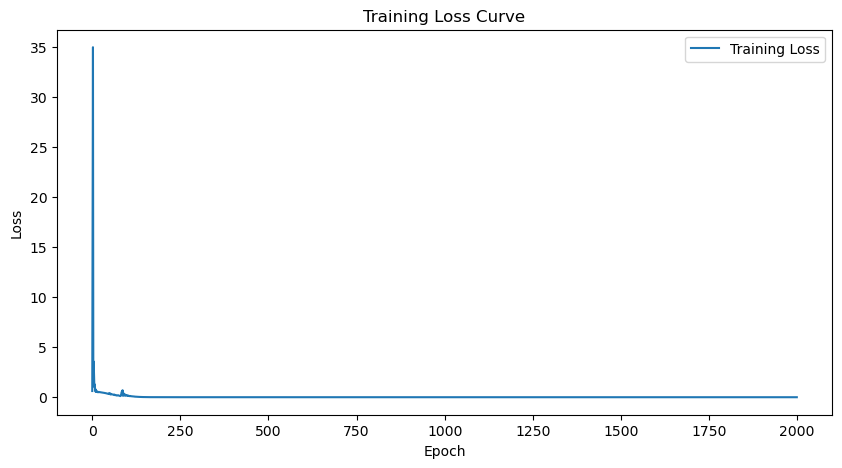

Final Model Accuracy: 72.88%
Final Model F1-score: 0.8431


In [20]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [21]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [ ]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00        30
non_infringement       0.74      0.98      0.84        88

        accuracy                           0.73       118
       macro avg       0.37      0.49      0.42       118
    weighted avg       0.55      0.73      0.63       118



/tmp/ipykernel_1415633/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 